In [2]:
%pip install xgboost yfinance pandas numpy matplotlib scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/b1/q44029jx1wbdmqw13ddfzf7m0000gn/T/ipykernel_25635/1354152044.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AMD', start='2022-04-01', end=datetime.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker             AMD         AMD         AMD         AMD        AMD
Date                                                                 
2022-04-01  108.190002  111.419998  106.099998  110.480003  111867100
2022-04-04  110.529999  110.940002  107.029999  109.970001   90123900
2022-04-05  106.820000  110.480003  106.050003  109.690002   79532000
2022-04-06  103.669998  105.739998  101.709999  104.449997  105256600
2022-04-07  103.720001  105.239998  100.910004  103.919998   91895500
Dataset shape: (856, 5)
Mean Squared Error on Validation: 31.25


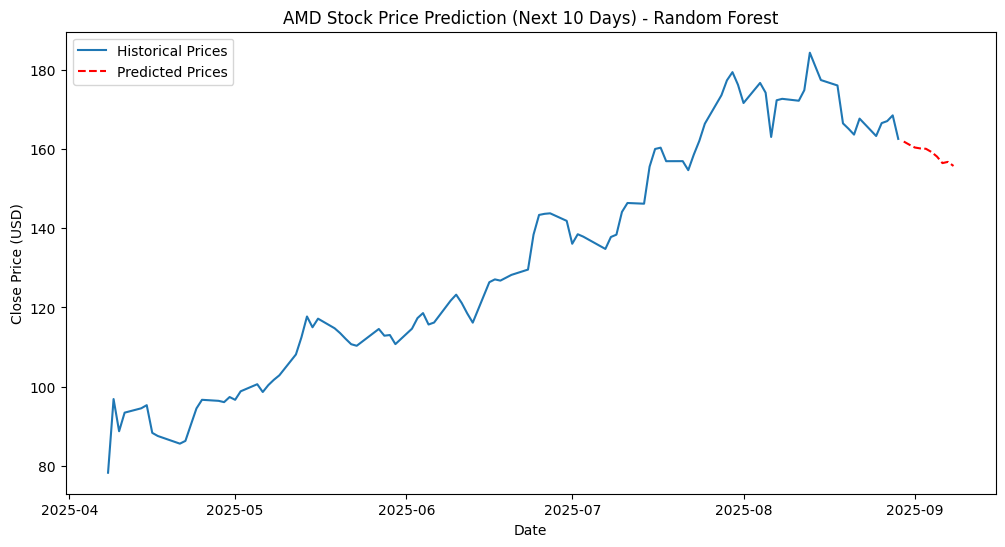

In [4]:
# Stock Price Prediction using Random Forest (Safe Version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error

# Step 1: Fetch AMD stock data
df = yf.download('AMD', start='2022-04-01', end=datetime.now().strftime('%Y-%m-%d'))

if df.empty:
    raise ValueError("No stock data fetched. Check ticker or internet connection.")

print(df.head())
print("Dataset shape:", df.shape)

# Step 2: Prepare Close prices
if 'Close' not in df.columns:
    raise ValueError("Downloaded data has no 'Close' column!")

data = df[['Close']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 3: Split train/validation
training_data_len = int(len(scaled_data) * 0.95)
train_data = scaled_data[:training_data_len]
valid_data = scaled_data[training_data_len:]

# Function to create dataset
def create_dataset(dataset, time_step=30):  # use 30-day window for safety
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_valid, y_valid = create_dataset(valid_data)

# Safety check: if validation is empty, fall back to last part of training
if X_valid.size == 0 or y_valid.size == 0:
    print("⚠️ Validation set too small. Using last part of training data instead.")
    split_point = int(len(train_data) * 0.8)
    X_valid, y_valid = create_dataset(train_data[split_point:])

# Step 4: Train Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
model.fit(X_train, y_train)

# Step 5: Evaluate
y_pred_scaled = model.predict(X_valid)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_valid_actual = scaler.inverse_transform(y_valid.reshape(-1, 1))

mse = mean_squared_error(y_valid_actual, y_pred)
print(f"Mean Squared Error on Validation: {mse:.2f}")

# Step 6: Predict next 10 days
last_30_days = scaled_data[-30:].reshape(1, -1)
future_prices = []

for i in range(10):
    pred_scaled = model.predict(last_30_days)[0]
    future_prices.append(pred_scaled)
    last_30_days = np.append(last_30_days[:, 1:], [[pred_scaled]], axis=1)

future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

# Future dates
last_date = df.index[-1]
future_dates = pd.date_range(last_date + timedelta(days=1), periods=10)

# Step 7: Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Close'].tail(100), label='Historical Prices')
plt.plot(future_dates, future_prices, linestyle='dashed', color='red', label='Predicted Prices')
plt.title('AMD Stock Price Prediction (Next 10 Days) - Random Forest')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()
